# Fish Weight Modeling for Market Insights

As a data scientist, I want to develop and compare different regression models to predict the weight of a fish so that I can provide an accurate pricing and sizing model for fish market management. 

In [79]:
# imports

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


#### Data Acquisition and Preparation

In [80]:
# Download latest version
path = kagglehub.dataset_download("vipullrathod/fish-market")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\bbuser\.cache\kagglehub\datasets\vipullrathod\fish-market\versions\1


In [81]:
print("Dataset files:", os.listdir(path))

Dataset files: ['Fish.csv']


In [82]:
csv_path = os.path.join(path, "Fish.csv")

df = pd.read_csv(csv_path)

df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [84]:
df['Height'].value_counts()

Height
5.6925     2
6.1100     2
11.1366    2
2.2139     2
9.6000     2
          ..
2.0904     1
2.4300     1
2.2770     1
2.8728     1
2.9322     1
Name: count, Length: 154, dtype: int64

In [85]:
df['Height'].unique()

array([11.52  , 12.48  , 12.3778, 12.73  , 12.444 , 13.6024, 14.1795,
       12.67  , 14.0049, 14.2266, 14.2628, 14.3714, 13.7592, 13.9129,
       14.9544, 15.438 , 14.8604, 14.938 , 15.633 , 14.4738, 15.1285,
       15.9936, 15.5227, 15.4686, 16.2405, 16.36  , 16.3618, 16.517 ,
       16.8896, 18.957 , 18.0369, 18.084 , 18.7542, 18.6354, 17.6235,
        4.1472,  5.2983,  5.5756,  5.6166,  6.216 ,  6.4752,  6.1677,
        6.1146,  5.8045,  6.6339,  7.0334,  6.55  ,  6.4   ,  7.5344,
        6.9153,  7.3968,  7.0866,  8.8768,  8.568 ,  9.485 ,  8.3804,
        8.1454,  8.778 , 10.744 , 11.7612, 12.354 ,  6.8475,  6.5772,
        7.4052,  8.3922,  8.8928,  8.5376,  9.396 ,  9.7364, 10.3458,
       11.088 , 11.368 ,  2.112 ,  3.528 ,  3.824 ,  4.5924,  4.588 ,
        5.2224,  5.1992,  5.6358,  5.1376,  5.082 ,  5.6925,  5.9175,
        6.384 ,  6.11  ,  5.64  ,  5.875 ,  5.5225,  5.856 ,  6.792 ,
        5.9532,  5.2185,  6.275 ,  7.293 ,  6.375 ,  6.7334,  6.4395,
        6.561 ,  7.1

In [86]:
df['Weight'].unique()

array([ 242. ,  290. ,  340. ,  363. ,  430. ,  450. ,  500. ,  390. ,
        475. ,  600. ,  700. ,  610. ,  650. ,  575. ,  685. ,  620. ,
        680. ,  725. ,  720. ,  714. ,  850. , 1000. ,  920. ,  955. ,
        925. ,  975. ,  950. ,   40. ,   69. ,   78. ,   87. ,  120. ,
          0. ,  110. ,  150. ,  145. ,  160. ,  140. ,  169. ,  161. ,
        200. ,  180. ,  272. ,  270. ,  306. ,  540. ,  800. ,   55. ,
         60. ,   90. ,  170. ,  273. ,  300. ,    5.9,   32. ,   51.5,
         70. ,  100. ,   80. ,   85. ,  115. ,  125. ,  130. ,  135. ,
        225. ,  188. ,  197. ,  218. ,  260. ,  265. ,  250. ,  320. ,
        514. ,  556. ,  840. ,  690. ,  900. ,  820. , 1015. , 1100. ,
        345. ,  456. ,  510. ,  567. ,  770. , 1250. , 1600. , 1550. ,
       1650. ,    6.7,    7.5,    7. ,    9.7,    9.8,    8.7,   10. ,
          9.9,   12.2,   13.4,   19.7,   19.9])

In [87]:
df['Species'].unique()

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [88]:
df['Species'].value_counts()

Species
Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: count, dtype: int64

In [89]:
df.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

In [90]:
df.duplicated().sum()

np.int64(0)

In [91]:
target_col = "Weight"
y = df[target_col]
X = df.drop(columns=[target_col])

In [92]:
# Identify columns automatically
categorical_cols = ["Species"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

In [93]:
# Preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
    ]
)

numeric_poly = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])
preprocessor_poly = ColumnTransformer(
    transformers=[
        ("num_poly", numeric_poly, numeric_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
    ]
)

In [94]:
# Train/Test split (no stratify for regression)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Exploratory Data Analysis and Feature Engineering

In [95]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


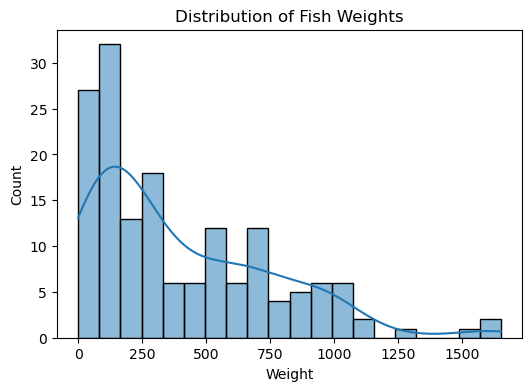

In [96]:
plt.figure(figsize=(6,4))
sns.histplot(df["Weight"], bins=20, kde=True)
plt.title("Distribution of Fish Weights")
plt.show()

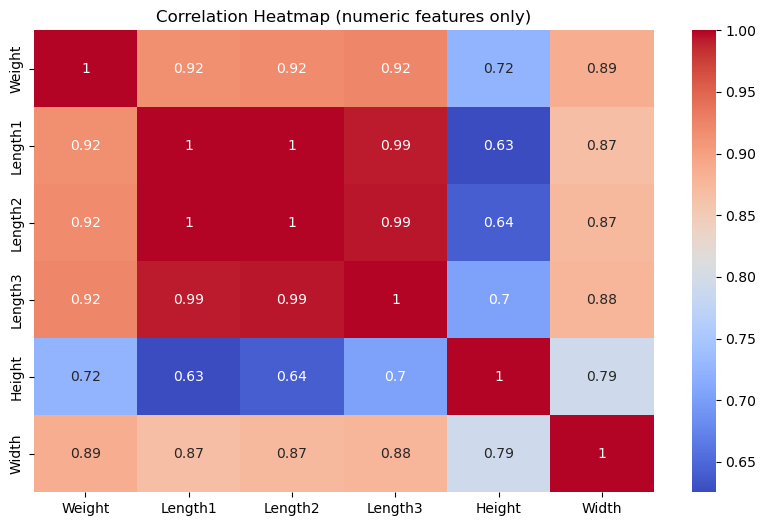

In [97]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features only)")
plt.show()

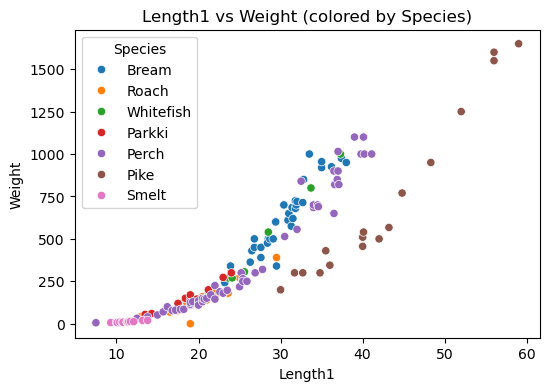

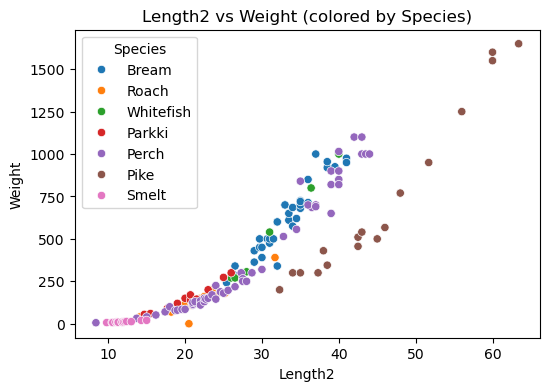

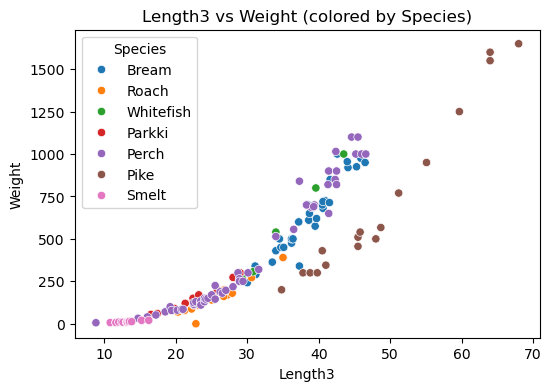

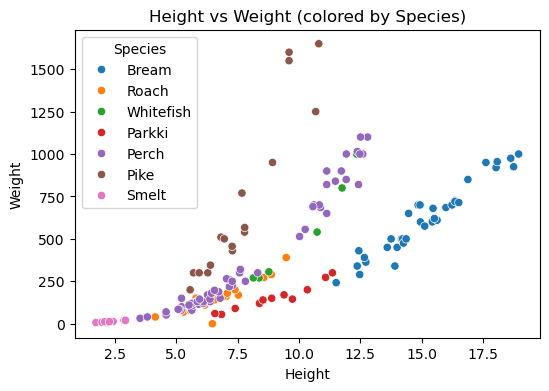

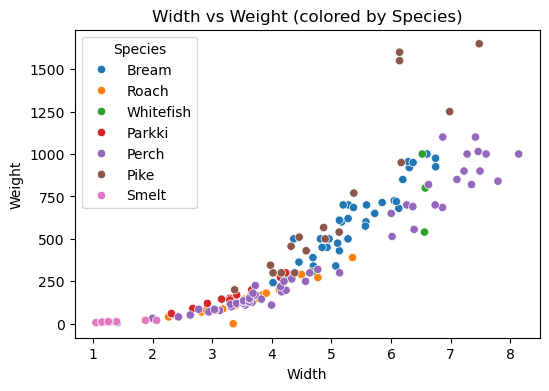

In [98]:
# Scatterplots of numeric features vs Weight
features = ["Length1", "Length2", "Length3", "Height", "Width"]
for col in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df["Weight"], hue=df["Species"])
    plt.title(f"{col} vs Weight (colored by Species)")
    plt.show()

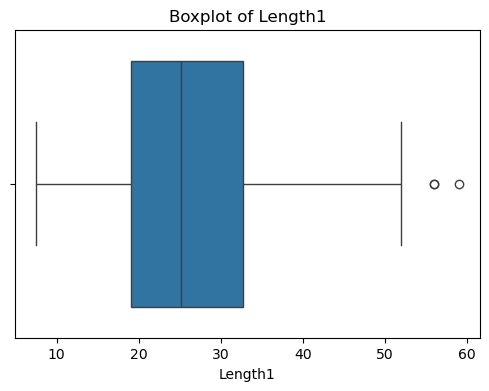

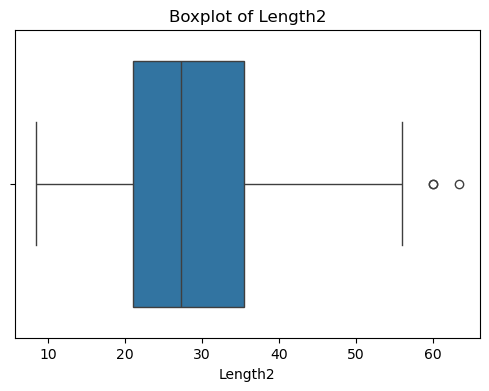

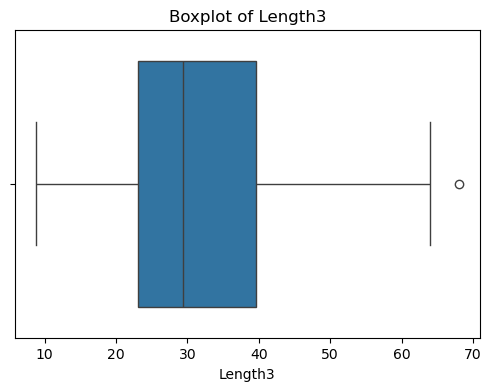

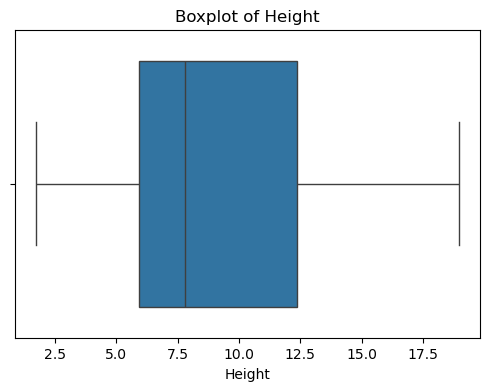

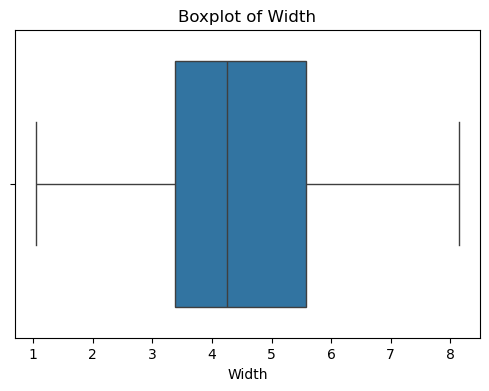

In [99]:
for col in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [100]:
# Z-score method
from scipy.stats import zscore

z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum()
print("Outliers per feature:\n", outliers)

Outliers per feature:
 6


In [101]:
# Identify which rows are outliers
outlier_rows = (z_scores > 3).any(axis=1)
print(df[outlier_rows])

    Species  Weight  Length1  Length2  Length3  Height  Width
142    Pike  1600.0     56.0     60.0     64.0   9.600  6.144
143    Pike  1550.0     56.0     60.0     64.0   9.600  6.144
144    Pike  1650.0     59.0     63.4     68.0  10.812  7.480


In [102]:
# Feature Engineering // Length ratio: captures proportion between two length measures
df["Length_ratio"] = df["Length2"] / df["Length3"]

# (b) Volume proxy: product of dimensions, useful predictor of weight
df["Volume"] = df["Length3"] * df["Height"] * df["Width"]

# Why?
# Fish weight is strongly related to its size/volume, not just one dimension.
# Ratios capture body shape differences between species.
# These engineered features often improve regression performance.


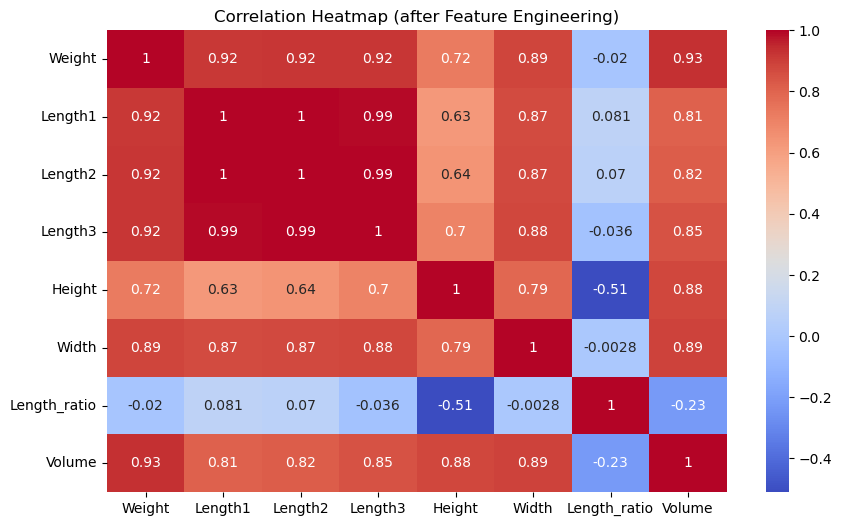

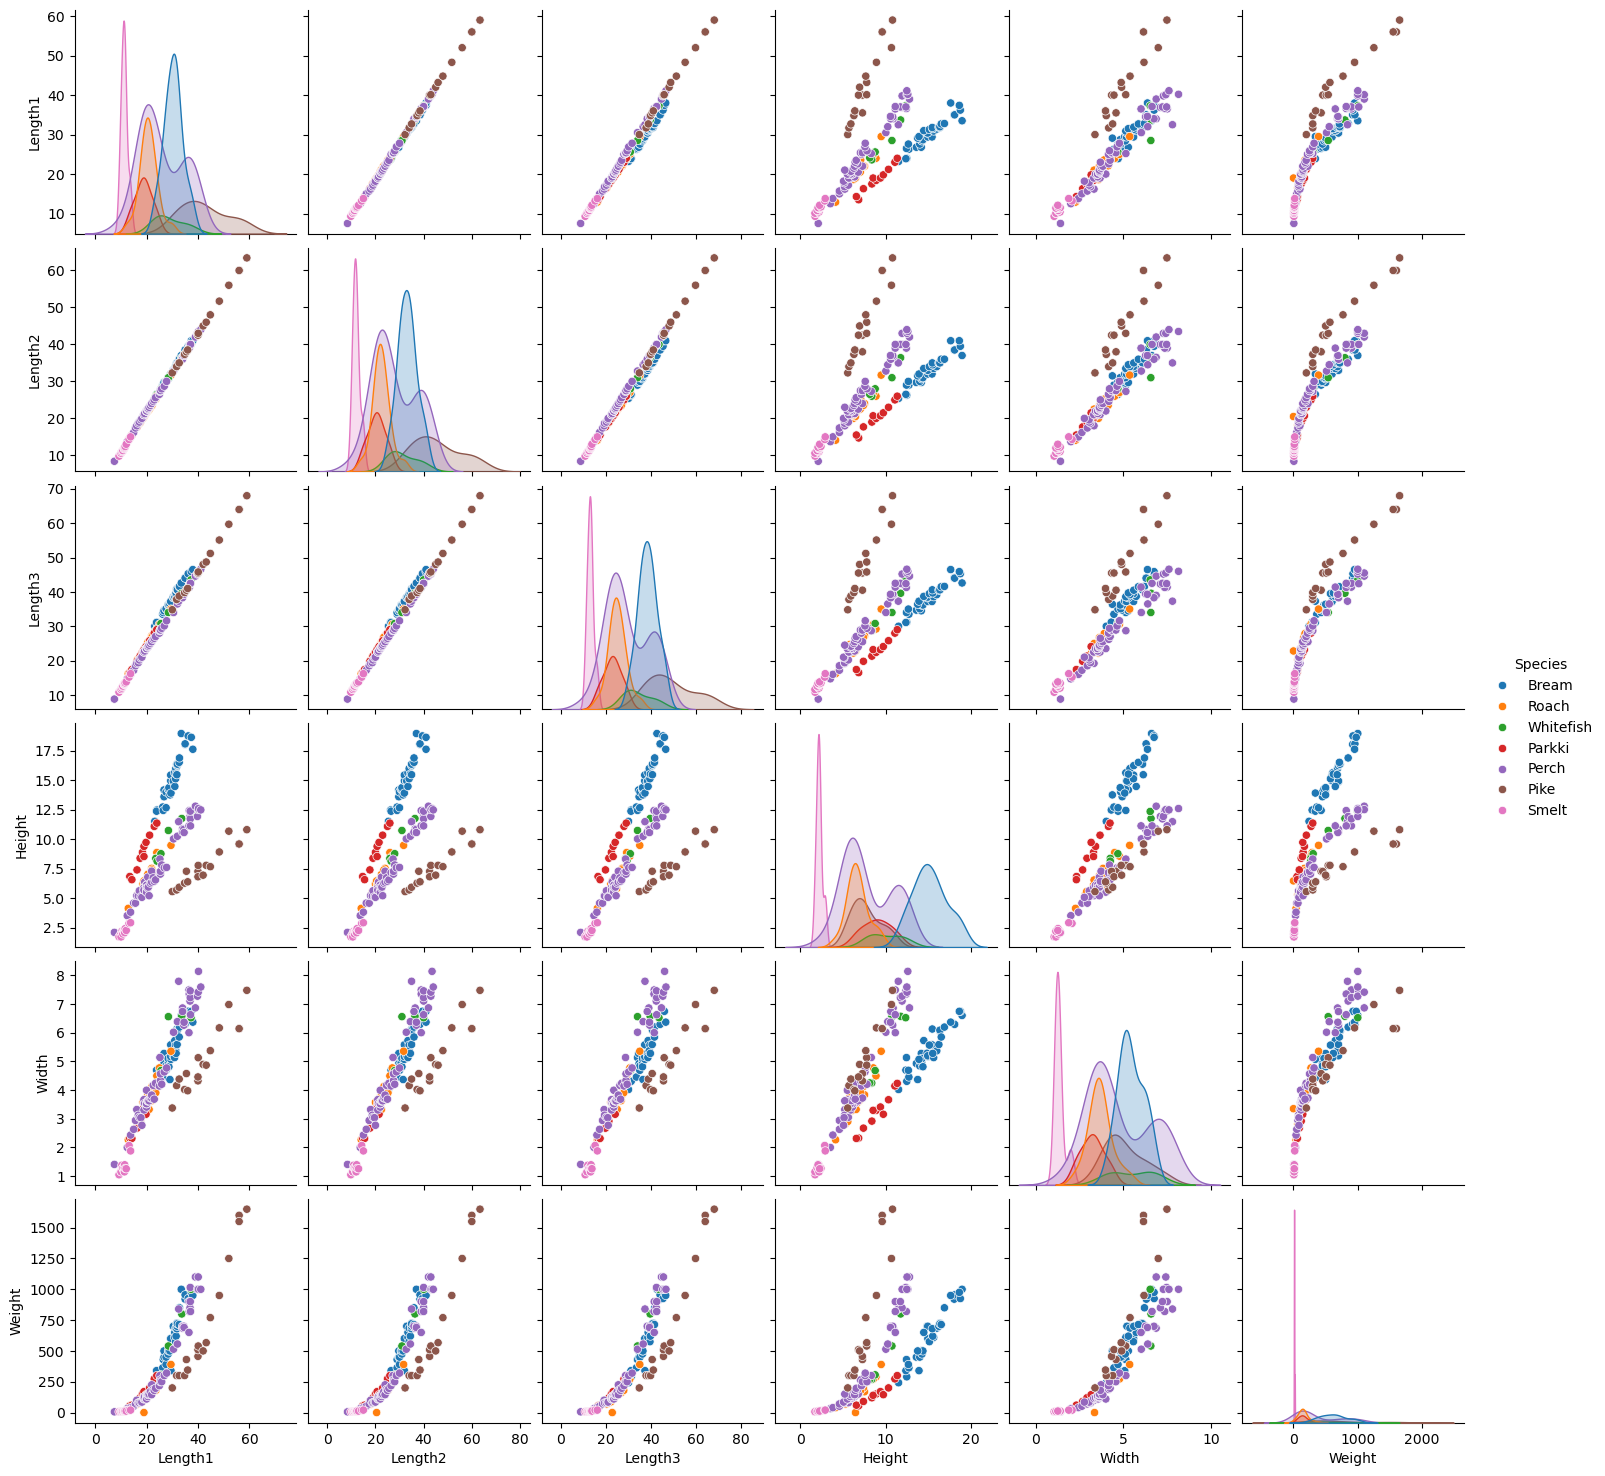

In [103]:
### FEATURE ENGINEERING ###

# Check correlations again after feature engineering
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (after Feature Engineering)")
plt.show()

# Pairplot grouped by species (for visual comparison)
sns.pairplot(df, vars=["Length1","Length2","Length3","Height","Width","Weight"], hue="Species")
plt.show()

#### Model Development and Comparison

In [104]:
# Models
models = {
    "Linear Regression": Pipeline([("prep", preprocessor), ("model", LinearRegression())]),
    "Ridge Regression": Pipeline([("prep", preprocessor), ("model", Ridge(alpha=1.0, random_state=42))]),
    "Lasso Regression": Pipeline([("prep", preprocessor), ("model", Lasso(alpha=0.01, random_state=42))]),
    "Polynomial Regression (deg=2)": Pipeline([("prep_poly", preprocessor_poly), ("model", LinearRegression())])
}


In [105]:
# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rows = []
for name, pipe in models.items():
    mse_scores = cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
    rmse_scores = np.sqrt(-mse_scores)
    r2_scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2")
    
    cv_rows.append({
        "Model": name,
        "CV Mean RMSE": rmse_scores.mean(),
        "CV Std RMSE": rmse_scores.std(),
        "CV Mean R2": r2_scores.mean(),
        "CV Std R2": r2_scores.std()
    })

cv_results = pd.DataFrame(cv_rows).sort_values("CV Mean RMSE")
print("\n===== 5-Fold Cross-Validation Results =====")
print(cv_results.to_string(index=False))

c:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.348e+05, tolerance: 1.561e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.479e+05, tolerance: 1.700e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.566e+05, toler


===== 5-Fold Cross-Validation Results =====
                        Model  CV Mean RMSE  CV Std RMSE  CV Mean R2  CV Std R2
Polynomial Regression (deg=2)     58.926099     3.256243    0.966812   0.016712
            Linear Regression     97.817049    19.067946    0.916074   0.028146
             Lasso Regression     99.148611    19.675138    0.915526   0.022805
             Ridge Regression     99.734860    22.117483    0.915876   0.020838


In [106]:
# Holdout evaluation
def evaluate_on_holdout(pipe, X_train, y_train, X_test, y_test, name):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {"Model": name, "Test RMSE": rmse, "Test R2": r2}

holdout_rows = []
for name, pipe in models.items():
    holdout_rows.append(evaluate_on_holdout(pipe, X_train, y_train, X_test, y_test, name))

holdout_results = pd.DataFrame(holdout_rows).sort_values("Test RMSE")
print("\n===== Holdout (Train/Test Split) Results =====")
print(holdout_results.to_string(index=False))



===== Holdout (Train/Test Split) Results =====
                        Model  Test RMSE  Test R2
Polynomial Regression (deg=2)  58.211159 0.976177
            Linear Regression  83.710114 0.950735
             Lasso Regression  87.821325 0.945777
             Ridge Regression  88.237001 0.945263


c:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.348e+05, tolerance: 1.561e+03
  model = cd_fast.enet_coordinate_descent(


In [107]:
# Picking the winner

best_cv = cv_results.sort_values("CV Mean RMSE").iloc[0]["Model"]
best_holdout = holdout_results.sort_values("Test RMSE").iloc[0]["Model"]
print(f"\nBest by CV (lowest RMSE): {best_cv}")
print(f"Best on Holdout (lowest RMSE): {best_holdout}")


Best by CV (lowest RMSE): Polynomial Regression (deg=2)
Best on Holdout (lowest RMSE): Polynomial Regression (deg=2)
